In [86]:
with open('libraries.py') as f:
    code = f.read()
exec(code)

with open('functions.py') as f:
    code = f.read()
exec(code)

In [87]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'

In [88]:
# Pick occupation and initialize variables
occupation = 'travelAgents'
# occupation = 'insuranceUnderwriters'
# occupation = 'pileDriverOperators'
# occupation = 'dredgeOperators'
# occupation = 'gradersAndSorters'
# occupation = 'reinforcingIron'
# occupation = 'insuranceAppraisers'
# occupation = 'floorSanders'
# occupation = 'dataEntryKeyer'
# # occupation = 'athletesAndSportsCompetitors'
# # # occupation = 'shampooers'

GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder = pick_occupation(occupation)

In [89]:
# Manual DAG only available for travel agents and insurance underwriters
# if working w/ these two occupations include manual DAG too, else discard relevant code
manual_present = 0
if occupation == 'travelAgents' or occupation == 'insuranceUnderwriters':
    manual_present = 1

### Read Data

In [90]:
if manual_present == 1:
    manual_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_M.csv')
naive_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_N.csv')
naive_conditioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_CN.csv')
firstLastTask_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_FLT.csv')
firstLastTask_conditioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_CFLT.csv')
partitioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_P.csv')
partitioned_conditioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_CP.csv')

In [91]:
partitioned_df.head()

,alpha,optimal_schemes_count,cost,optimal_scheme,optimal_scheme_augmented_tasks,augmented_tasks_count,optimal_scheme_human_tasks,human_tasks_count
0,0.00,1,330.00,"[[0], [1], [2], [3], [4], [5], [6], [7]]",[],0,"[[0], [1], [2], [3], [4], [5], [6], [7]]",8
1,0.01,1,284.82,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [7]]",2,"[[0], [1], [3], [4], [5], [6]]",6
2,0.02,1,273.97,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5
3,0.03,1,268.26,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5
4,0.04,1,264.62,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5


In [92]:
# get number of tasks in occupation
onet = pd.read_csv(f'{data_path}/data/onet_occupations_yearly.csv')
onet = onet.sort_values(by=['year', 'occ_code', 'occ_title', 'task_id'])
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# Get list of tasks
my_df = onet[(onet.occ_code == f'{occupation_code}') & (onet.year == 2023)]
tasks = my_df['task'].unique().tolist()
tasks = [task.replace("'", "") for task in tasks] # remove apastrophes so partitions DAG code can handle task strings
num_tasks = len(tasks)

In [93]:
def get_manual_to_machine_tasks(df):
    # Convert the string representation of lists into actual Python lists
    for col in ['optimal_scheme', 'optimal_scheme_augmented_tasks', 'optimal_scheme_human_tasks']:
        df[col] = df[col].apply(ast.literal_eval)

    # Define a function to subtract lists in the next row from lists in the current row
    def subtract_lists(current_list, next_list):
        # Flatten lists for easier comparison
        current_flat = [item for sublist in current_list for item in sublist]
        next_flat = [item for sublist in next_list for item in sublist]
        
        # Subtract elements
        result_flat = [item for item in current_flat if item not in next_flat]
        
        # Rebuild the list of lists structure
        result_list = [[item] for item in result_flat]
        return result_list

    # Create the new column by applying the function to each row
    new_column = [[]]
    for i in range(1, len(df)):
        current_list = df.loc[i - 1, 'optimal_scheme_human_tasks']
        next_list = df.loc[i, 'optimal_scheme_human_tasks']
        new_column.append(subtract_lists(current_list, next_list))

    # Assign the new column to the DataFrame
    df['newly_automated_tasks'] = new_column
    
    # Replace empty lists with an empty string
    df['newly_automated_tasks'] = df['newly_automated_tasks'].apply(lambda x: '' if x == [] else x)

    return df

naive_df = get_manual_to_machine_tasks(naive_df)
naive_conditioned_df = get_manual_to_machine_tasks(naive_conditioned_df)
firstLastTask_df = get_manual_to_machine_tasks(firstLastTask_df)
firstLastTask_conditioned_df = get_manual_to_machine_tasks(firstLastTask_conditioned_df)
partitioned_df = get_manual_to_machine_tasks(partitioned_df)
partitioned_conditioned_df = get_manual_to_machine_tasks(partitioned_conditioned_df)

In [94]:
partitioned_df.head()

,alpha,optimal_schemes_count,cost,optimal_scheme,optimal_scheme_augmented_tasks,augmented_tasks_count,optimal_scheme_human_tasks,human_tasks_count,newly_automated_tasks
0,0.00,1,330.00,"[[0], [1], [2], [3], [4], [5], [6], [7]]",[],0,"[[0], [1], [2], [3], [4], [5], [6], [7]]",8,
1,0.01,1,284.82,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [7]]",2,"[[0], [1], [3], [4], [5], [6]]",6,"[[2], [7]]"
2,0.02,1,273.97,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,[[6]]
3,0.03,1,268.26,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,
4,0.04,1,264.62,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,


In [95]:
def get_fraction_task_type(df, num_tasks):
    df['frac_augmented'] = df.apply(lambda row: row['augmented_tasks_count'] / num_tasks, axis = 1)
    df['frac_human'] = df.apply(lambda row: row['human_tasks_count'] / num_tasks, axis = 1)
    df['frac_automated'] = 1 - df['frac_augmented'] - df['frac_human']
    return df

naive_df = get_fraction_task_type(naive_df, num_tasks)
naive_conditioned_df = get_fraction_task_type(naive_conditioned_df, num_tasks)
firstLastTask_df = get_fraction_task_type(firstLastTask_df, num_tasks)
firstLastTask_conditioned_df = get_fraction_task_type(firstLastTask_conditioned_df, num_tasks)
partitioned_df = get_fraction_task_type(partitioned_df, num_tasks)
partitioned_conditioned_df = get_fraction_task_type(partitioned_conditioned_df, num_tasks)

In [96]:
partitioned_df.head()

,alpha,optimal_schemes_count,cost,optimal_scheme,optimal_scheme_augmented_tasks,augmented_tasks_count,optimal_scheme_human_tasks,human_tasks_count,newly_automated_tasks,frac_augmented,frac_human,frac_automated
0,0.00,1,330.00,"[[0], [1], [2], [3], [4], [5], [6], [7]]",[],0,"[[0], [1], [2], [3], [4], [5], [6], [7]]",8,,0.00,1.00,0.00
1,0.01,1,284.82,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [7]]",2,"[[0], [1], [3], [4], [5], [6]]",6,"[[2], [7]]",0.25,0.75,0.00
2,0.02,1,273.97,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,[[6]],0.38,0.62,0.00
3,0.03,1,268.26,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,,0.38,0.62,0.00
4,0.04,1,264.62,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,,0.38,0.62,0.00


In [97]:
# Function to calculate the average length of automated chain
def calc_avg_automationPlan_size(row):
    all_partitions = row['optimal_scheme']
    if len(all_partitions) == 3:
        print(row['alpha'])
    human_tasks = row['optimal_scheme_human_tasks']
    
    # Calculate the lengths of each sublist
    if len(all_partitions) != len(human_tasks):
        length = [len(partition) for partition in all_partitions if partition not in human_tasks]
    else:
        return 0
    
    # Compute the average length
    if length:  # Check to avoid division by zero
        return sum(length) / len(length)
    else:
        return 0
    

# Function to calculate the max length of automated chain
def calc_max_automationPlan_size(row):
    all_partitions = row['optimal_scheme']
    human_tasks = row['optimal_scheme_human_tasks']
    
    # Calculate the lengths of each sublist
    if len(all_partitions) != len(human_tasks):
        length = [len(partition) for partition in all_partitions if partition not in human_tasks]
    else:
        return 0
    
    # Compute the average length
    if length:  # Check to avoid division by zero
        return max(length)
    else:
        return 0
    

def create_pretty_name(row):
    optimal_scheme_str = 'optimal_scheme'
    optimal_scheme_human_tasks_str = 'optimal_scheme_human_tasks'
    optimal_scheme_augmented_tasks_str = 'optimal_scheme_augmented_tasks'
    
    # Convert string representations of lists into actual lists
    list_a = row[optimal_scheme_str]
    list_b = row[optimal_scheme_human_tasks_str]
    # list_c = row[optimal_scheme_augmented_tasks_str]
    

    # Iterate over elements in list_b
    for sublist_b in list_b:
        # Replace matching lists in list_a with the formatted string
        list_a = [
            f"<{sublist_b[0]}>" if sublist == sublist_b else sublist
            for sublist in list_a
        ]

    # # Iterate over elements in list_a to wrap unmatched items with ()
    # for i, sublist_a in enumerate(list_a):
    #     if isinstance(sublist_a, list):
    #         list_a[i] = [
    #             f"({str(item)})" if not any(item in sublist_c for sublist_c in list_c) else item
    #             for item in sublist_a
    #         ]

    # Convert the list back to a string without quotes around "<x>"
    return "[" + ", ".join(
        str(item) if isinstance(item, list) else item
        for item in list_a
    ) + "]"


In [98]:
# naive_df['avg_automationChain_size'] = naive_df.apply(calc_avg_automationPlan_size, axis=1)
# naive_conditioned_df['avg_automationChain_size'] = naive_conditioned_df.apply(calc_avg_automationPlan_size, axis=1)
# firstLastTask_df['avg_automationChain_size'] = firstLastTask_df.apply(calc_avg_automationPlan_size, axis=1)
# firstLastTask_conditioned_df['avg_automationChain_size'] = firstLastTask_conditioned_df.apply(calc_avg_automationPlan_size, axis=1)
# partitioned_df['avg_automationChain_size'] = partitioned_df.apply(calc_avg_automationPlan_size, axis=1)
# partitioned_conditioned_df['avg_automationChain_size'] = partitioned_conditioned_df.apply(calc_avg_automationPlan_size, axis=1)

# naive_df['max_automationChain_size'] = naive_df.apply(calc_max_automationPlan_size, axis=1)
# naive_conditioned_df['max_automationChain_size'] = naive_conditioned_df.apply(calc_max_automationPlan_size, axis=1)
# firstLastTask_df['max_automationChain_size'] = firstLastTask_df.apply(calc_max_automationPlan_size, axis=1)
# firstLastTask_conditioned_df['max_automationChain_size'] = firstLastTask_conditioned_df.apply(calc_max_automationPlan_size, axis=1)
# partitioned_df['max_automationChain_size'] = partitioned_df.apply(calc_max_automationPlan_size, axis=1)
# partitioned_conditioned_df['max_automationChain_size'] = partitioned_conditioned_df.apply(calc_max_automationPlan_size, axis=1)

naive_df['pretty_name'] = naive_df.apply(create_pretty_name, axis=1)
naive_conditioned_df['pretty_name'] = naive_conditioned_df.apply(create_pretty_name, axis=1)
firstLastTask_df['pretty_name'] = firstLastTask_df.apply(create_pretty_name, axis=1)
firstLastTask_conditioned_df['pretty_name'] = firstLastTask_conditioned_df.apply(create_pretty_name, axis=1)
partitioned_df['pretty_name'] = partitioned_df.apply(create_pretty_name, axis=1)
partitioned_conditioned_df['pretty_name'] = partitioned_conditioned_df.apply(create_pretty_name, axis=1)


In [99]:
partitioned_df.head()

,alpha,optimal_schemes_count,cost,optimal_scheme,optimal_scheme_augmented_tasks,augmented_tasks_count,optimal_scheme_human_tasks,human_tasks_count,newly_automated_tasks,frac_augmented,frac_human,frac_automated,pretty_name
0,0.00,1,330.00,"[[0], [1], [2], [3], [4], [5], [6], [7]]",[],0,"[[0], [1], [2], [3], [4], [5], [6], [7]]",8,,0.00,1.00,0.00,"[<0>, <1>, <2>, <3>, <4>, <5>, <6>, <7>]"
1,0.01,1,284.82,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [7]]",2,"[[0], [1], [3], [4], [5], [6]]",6,"[[2], [7]]",0.25,0.75,0.00,"[<0>, <1>, [2], <3>, <4>, <5>, <6>, [7]]"
2,0.02,1,273.97,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,[[6]],0.38,0.62,0.00,"[<0>, <1>, [2], <3>, <4>, <5>, [6], [7]]"
3,0.03,1,268.26,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,,0.38,0.62,0.00,"[<0>, <1>, [2], <3>, <4>, <5>, [6], [7]]"
4,0.04,1,264.62,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[[2], [6], [7]]",3,"[[0], [1], [3], [4], [5]]",5,,0.38,0.62,0.00,"[<0>, <1>, [2], <3>, <4>, <5>, [6], [7]]"


### Create new dataset comparing DAGs stats

In [100]:
cols_to_keep = ['alpha', 'cost', 'pretty_name', 
                'optimal_scheme_augmented_tasks', 'newly_automated_tasks', 
                'optimal_schemes_count', 
                'frac_augmented', 'frac_human', 'frac_automated']
if manual_present == 1:
    # prepare manual dataset
    manual_df = get_manual_to_machine_tasks(manual_df) 
    manual_df = get_fraction_task_type(manual_df, num_tasks)
    # manual_df['avg_automationChain_size'] = manual_df.apply(calc_avg_automationPlan_size, axis=1)
    # manual_df['max_automationChain_size'] = manual_df.apply(calc_max_automationPlan_size, axis=1)
    manual_df['pretty_name'] = manual_df.apply(create_pretty_name, axis=1)
    
    # merge datasets
    comparison_df = pd.merge(manual_df[cols_to_keep], 
                            naive_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_M', '_N'))
    comparison_df = pd.merge(comparison_df, 
                            naive_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')
    comparison_df = pd.merge(comparison_df, 
                            firstLastTask_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_CN', '_FLT'))
    comparison_df = pd.merge(comparison_df,
                            firstLastTask_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')
    comparison_df = pd.merge(comparison_df,
                            partitioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_CFLT', '_P'))
    comparison_df = pd.merge(comparison_df,
                            partitioned_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')

    # change column names
    comparison_df = comparison_df.rename(columns={'pretty_name': 'optimal_scheme_CP',
                                                'cost': 'cost_CP', 
                                                'optimal_scheme_augmented_tasks': 'optimal_scheme_augmented_tasks_CP',
                                                'newly_automated_tasks': 'newly_automated_tasks_CP',
                                                'optimal_schemes_count': 'optimal_schemes_count_CP',
                                                'frac_augmented': 'frac_augmented_CP',
                                                'frac_human': 'frac_human_CP',
                                                'frac_automated': 'frac_automated_CP'})
else:
    # merge datasets
    comparison_df = pd.merge(naive_df[cols_to_keep], 
                            naive_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_N', '_CN'))
    comparison_df = pd.merge(comparison_df, 
                            firstLastTask_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')
    comparison_df = pd.merge(comparison_df,
                            firstLastTask_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_FLT', '_CFLT'))
    comparison_df = pd.merge(comparison_df,
                            partitioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')
    comparison_df = pd.merge(comparison_df,
                            partitioned_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_P', '_CP'))

# hacky way to fix column names after merge
comparison_df.columns = comparison_df.columns.str.replace('pretty_name', 'optimal_scheme')

for col in comparison_df.columns:
    if "optimal_scheme_" in col:
        # Create a new column indicating where the value changes
        change_col = col + '_change'
        comparison_df[change_col] = (comparison_df[col] != comparison_df[col].shift()).cumsum() - 1


# # change ordering of columns
# sorted_cols = sorted(comparison_df.columns, key=lambda x: x.split('_')[-1])
# comparison_df = comparison_df[sorted_cols]

# save output
comparison_df.to_csv(f'{occupation_folder}/{occupation}_costMin_DAGcomparison_df.csv', index=False)

## Plots

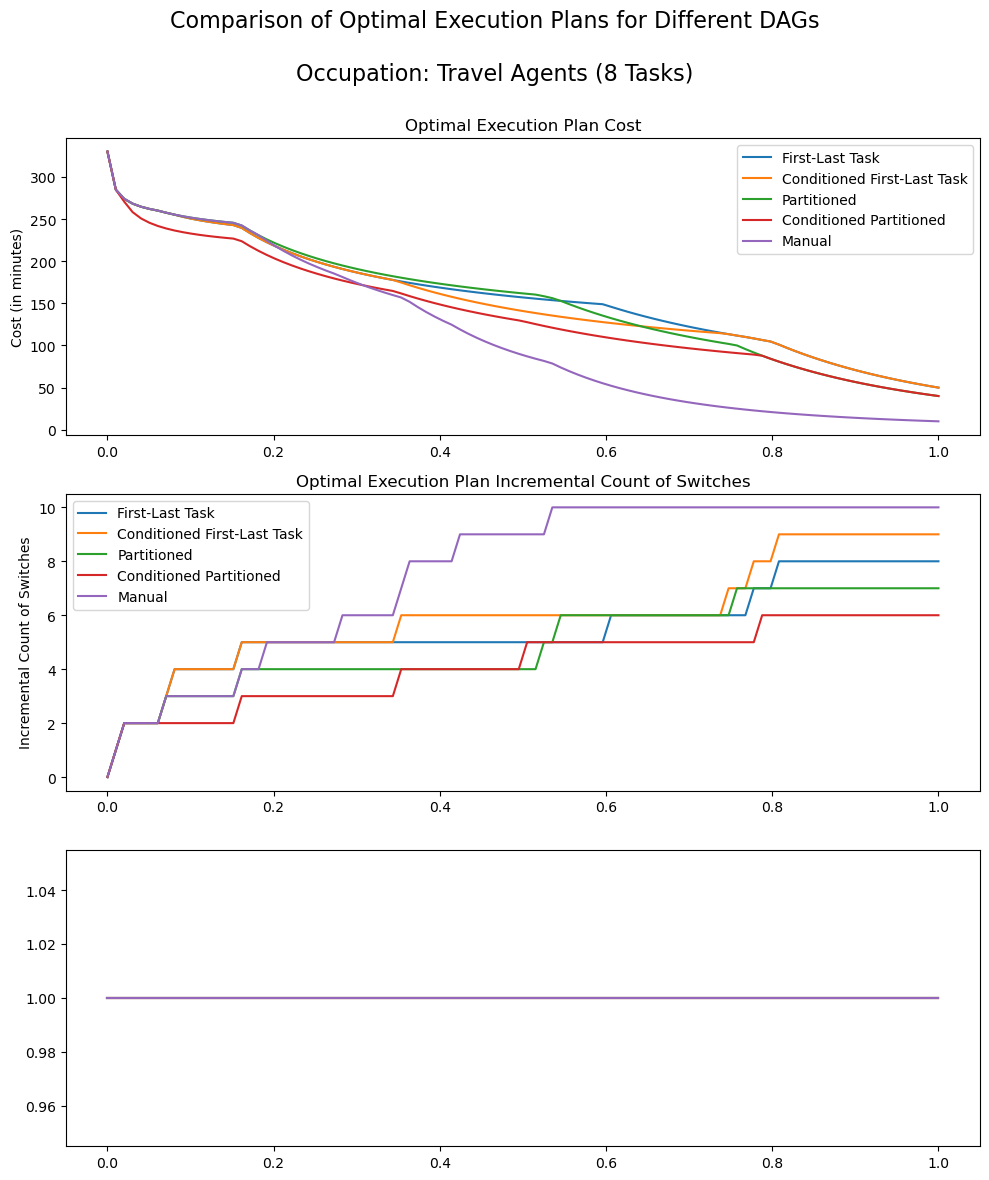

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle(f'Comparison of Optimal Execution Plans for Different DAGs\n\nOccupation: {plot_title_occupation} ({num_tasks} Tasks)\n', fontsize=16)

# Plot data on the first subplot
ax1.plot(comparison_df.alpha, comparison_df.cost_FLT, label = 'First-Last Task')
ax1.plot(comparison_df.alpha, comparison_df.cost_CFLT, label = 'Conditioned First-Last Task')
ax1.plot(comparison_df.alpha, comparison_df.cost_P, label = 'Partitioned')
ax1.plot(comparison_df.alpha, comparison_df.cost_CP, label = 'Conditioned Partitioned')
if manual_present == 1:
    ax1.plot(comparison_df.alpha, comparison_df.cost_M, label = 'Manual')

ax1.set_title('Optimal Execution Plan Cost')
#ax1.set_xlabel(r'AI Quality ($\alpha$)')
ax1.set_ylabel('Cost (in minutes)')
ax1.legend(loc='upper right')


# Plot data on the second subplot
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_FLT_change, label = 'First-Last Task')
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_CFLT_change, label = 'Conditioned First-Last Task')
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_P_change, label = 'Partitioned')
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_CP_change, label = 'Conditioned Partitioned')
if manual_present == 1:
    ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_M_change, label = 'Manual')

ax2.set_title('Optimal Execution Plan Incremental Count of Switches')
#ax2.set_xlabel(r'AI Quality ($\alpha$)')
ax2.set_ylabel('Incremental Count of Switches')
ax2.legend(loc='upper left')


# Plot data on the third subplot
ax3.plot(comparison_df.alpha, comparison_df.optimal_schemes_count_FLT, label = 'First-Last Task')
ax3.plot(comparison_df.alpha, comparison_df.optimal_schemes_count_CFLT, label = 'Conditioned First-Last Task')
ax3.plot(comparison_df.alpha, comparison_df.optimal_schemes_count_P, label = 'Partitioned')
ax3.plot(comparison_df.alpha, comparison_df.optimal_schemes_count_CP, label = 'Conditioned Partitioned')
if manual_present == 1:
    ax3.plot(comparison_df.alpha, comparison_df.optimal_schemes_count_M, label = 'Manual')


# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig(f'{occupation_folder}/{occupation}_costMin_graph.png', dpi=300)
plt.savefig(f'{data_path}/daily_tasks_occupations_analysis/plots/costMin/{occupation}_costMin_graph.png', dpi=300)

# # Close figure
# plt.close()

In [104]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
# fig.suptitle(f'Comparison of Optimal Execution Plans for Different DAGs\n\nOccupation: {plot_title_occupation} ({num_tasks} Tasks)\n', fontsize=16)

# # Plot data on the first subplot
# ax1.plot(comparison_df.alpha, comparison_df.avg_automationChain_size_FLT, label = 'First-Last Task')
# ax1.plot(comparison_df.alpha, comparison_df.avg_automationChain_size_CFLT, label = 'Conditioned First-Last Task')
# ax1.plot(comparison_df.alpha, comparison_df.avg_automationChain_size_P, label = 'Partitioned')
# ax1.plot(comparison_df.alpha, comparison_df.avg_automationChain_size_CP, label = 'Conditioned Partitioned')
# if manual_present == 1:
#     ax1.plot(comparison_df.alpha, comparison_df.avg_automationChain_size_M, label = 'Manual')

# ax1.set_title('Avg. Size of Automated Chains in Optimal Execution Plan')
# #ax1.set_xlabel(r'AI Quality ($\alpha$)')
# ax1.set_ylabel('Avg. Size of Automated Chains')
# ax1.legend(loc='upper left')


# # Plot data on the second subplot
# ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_FLT_change, label = 'First-Last Task')
# ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_CFLT_change, label = 'Conditioned First-Last Task')
# ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_P_change, label = 'Partitioned')
# ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_CP_change, label = 'Conditioned Partitioned')
# if manual_present == 1:
#     ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_M_change, label = 'Manual')

# ax2.set_title('Optimal Execution Plan Incremental Count of Switches')
# #ax2.set_xlabel(r'AI Quality ($\alpha$)')
# ax2.set_ylabel('Incremental Count of Switches')
# ax2.legend(loc='upper left')


# # Plot data on the third subplot
# #ax3.axhline(y=-0, linestyle='--', alpha=0.9)
# ax3.plot(firstLastTask_df.alpha, firstLastTask_df.human_tasks_count, label = 'First-Last Task')
# ax3.plot(firstLastTask_conditioned_df.alpha, firstLastTask_conditioned_df.human_tasks_count, label = 'Conditioned First-Last Task')
# ax3.plot(partitioned_df.alpha, partitioned_df.human_tasks_count, label = 'Partitioned')
# ax3.plot(partitioned_conditioned_df.alpha, partitioned_conditioned_df.human_tasks_count, label = 'Conditioned Partitioned')
# if manual_present == 1:
#     ax3.plot(manual_df.alpha, manual_df.human_tasks_count, label = 'Manual')

# ax3.set_title('Count of Non-automated Tasks in Optimal Execution Plan(s)')
# #ax3.set_xlabel(r'AI Quality ($\alpha$)')
# ax3.set_ylabel('Count of Non-automated Tasks')
# ax3.legend(loc='upper right')


# # Plot data on the fourth subplot
# ax4.plot(comparison_df.alpha, comparison_df.max_automationChain_size_FLT, label = 'First-Last Task')
# ax4.plot(comparison_df.alpha, comparison_df.max_automationChain_size_CFLT, label = 'Conditioned First-Last Task')
# ax4.plot(comparison_df.alpha, comparison_df.max_automationChain_size_P, label = 'Partitioned')
# ax4.plot(comparison_df.alpha, comparison_df.max_automationChain_size_CP, label = 'Conditioned Partitioned')
# if manual_present == 1:
#     ax4.plot(comparison_df.alpha, comparison_df.max_automationChain_size_M, label = 'Manual')

# ax4.set_title('Max. Size of Automated Chains in Optimal Execution Plan')
# ax4.set_xlabel(r'AI Quality ($\alpha$)')
# ax4.set_ylabel('Max. Size of Automated Chains')
# ax4.legend(loc='upper left')

# # Adjust the layout
# plt.tight_layout()

# # Save the plot
# plt.savefig(f'{occupation_folder}/{occupation}_costMin_graph.png', dpi=300)
# plt.savefig(f'{data_path}/daily_tasks_occupations_analysis/plots/{occupation}_costMin_graph.png', dpi=300)

# # Close figure
# plt.close()

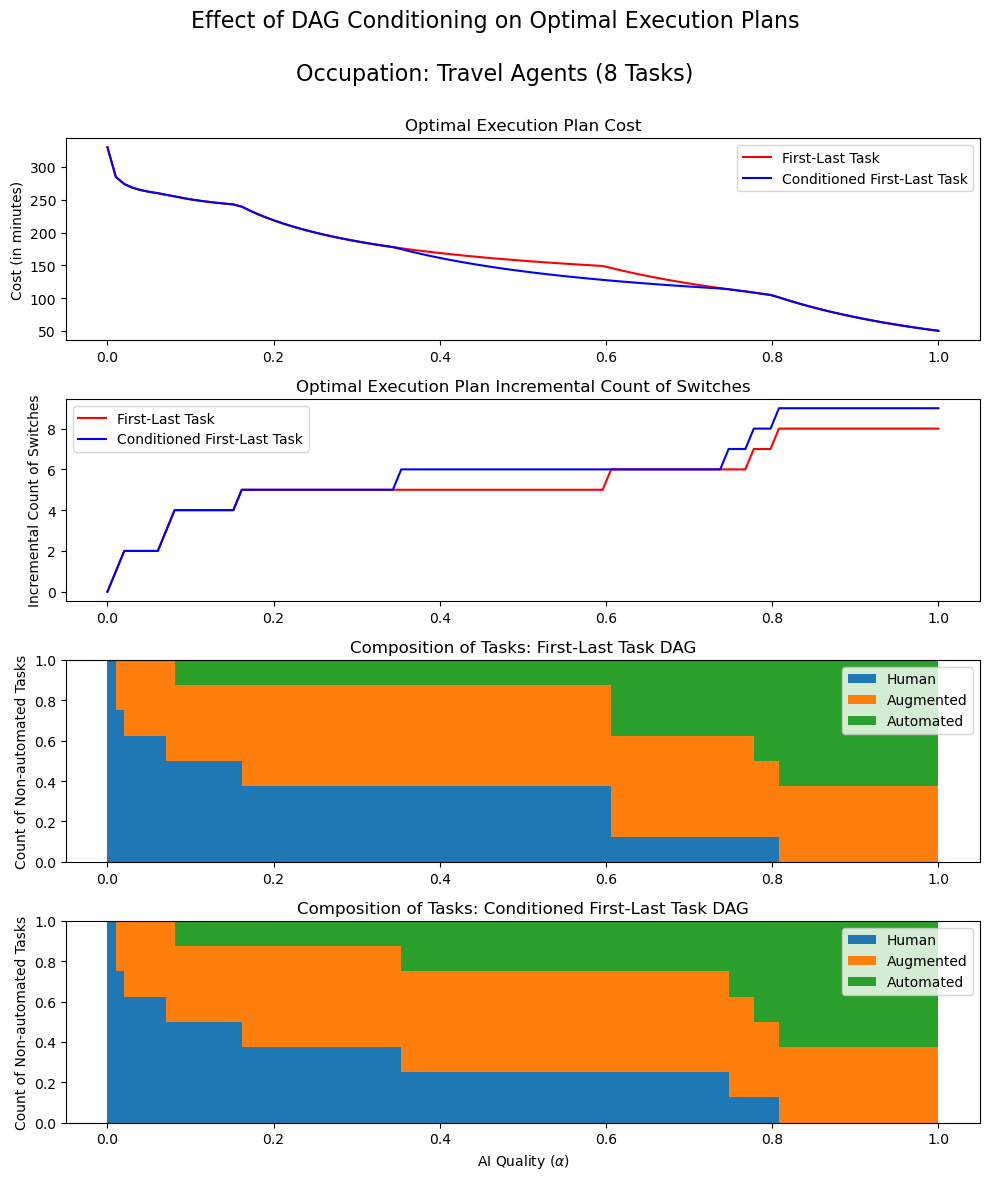

In [105]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
fig.suptitle(f'Effect of DAG Conditioning on Optimal Execution Plans\n\nOccupation: {plot_title_occupation} ({num_tasks} Tasks)\n', fontsize=16)

# Plot data on the first subplot
ax1.plot(comparison_df.alpha, comparison_df.cost_FLT, label = 'First-Last Task', color='red')
ax1.plot(comparison_df.alpha, comparison_df.cost_CFLT, label = 'Conditioned First-Last Task', color='blue')

ax1.set_title('Optimal Execution Plan Cost')
#ax1.set_xlabel(r'AI Quality ($\alpha$)')
ax1.set_ylabel('Cost (in minutes)')
ax1.legend(loc='upper right')


# Plot data on the second subplot
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_FLT_change, label = 'First-Last Task', color='red')
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_CFLT_change, label = 'Conditioned First-Last Task', color='blue')

ax2.set_title('Optimal Execution Plan Incremental Count of Switches')
#ax2.set_xlabel(r'AI Quality ($\alpha$)')
ax2.set_ylabel('Incremental Count of Switches')
ax2.legend(loc='upper left')


# Plot data on the third subplot
alpha_list = comparison_df.alpha.tolist()
widths = np.diff(alpha_list, append=alpha_list[-1])
ax3.bar(comparison_df.alpha, comparison_df.frac_human_FLT, width=widths, align='edge', label='Human')
ax3.bar(comparison_df.alpha, comparison_df.frac_augmented_FLT, bottom=comparison_df.frac_human_FLT, width=widths, align='edge', label='Augmented')
ax3.bar(comparison_df.alpha, comparison_df.frac_automated_FLT, bottom=comparison_df.frac_human_FLT + comparison_df.frac_augmented_FLT, width=widths, align='edge', label='Automated')

ax3.set_title('Composition of Tasks: First-Last Task DAG')
#ax3.set_xlabel(r'AI Quality ($\alpha$)')
ax3.set_ylabel('Count of Non-automated Tasks')
ax3.legend(loc='upper right')



ax4.bar(comparison_df.alpha, comparison_df.frac_human_CFLT, width=widths, align='edge', label='Human')
ax4.bar(comparison_df.alpha, comparison_df.frac_augmented_CFLT, bottom=comparison_df.frac_human_CFLT, width=widths, align='edge', label='Augmented')
ax4.bar(comparison_df.alpha, comparison_df.frac_automated_CFLT, bottom=comparison_df.frac_human_CFLT + comparison_df.frac_augmented_CFLT, width=widths, align='edge', label='Automated')

ax4.set_title('Composition of Tasks: Conditioned First-Last Task DAG')
ax4.set_xlabel(r'AI Quality ($\alpha$)')
ax4.set_ylabel('Count of Non-automated Tasks')
ax4.legend(loc='upper right')

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig(f'{occupation_folder}/{occupation}_conditioningComparison_FLT_graph.png', dpi=300)
plt.savefig(f'{data_path}/daily_tasks_occupations_analysis/plots/FLT_conditioning/{occupation}_conditioningComparison_FLT_graph.png', dpi=300)

# # Close figure
# plt.close()

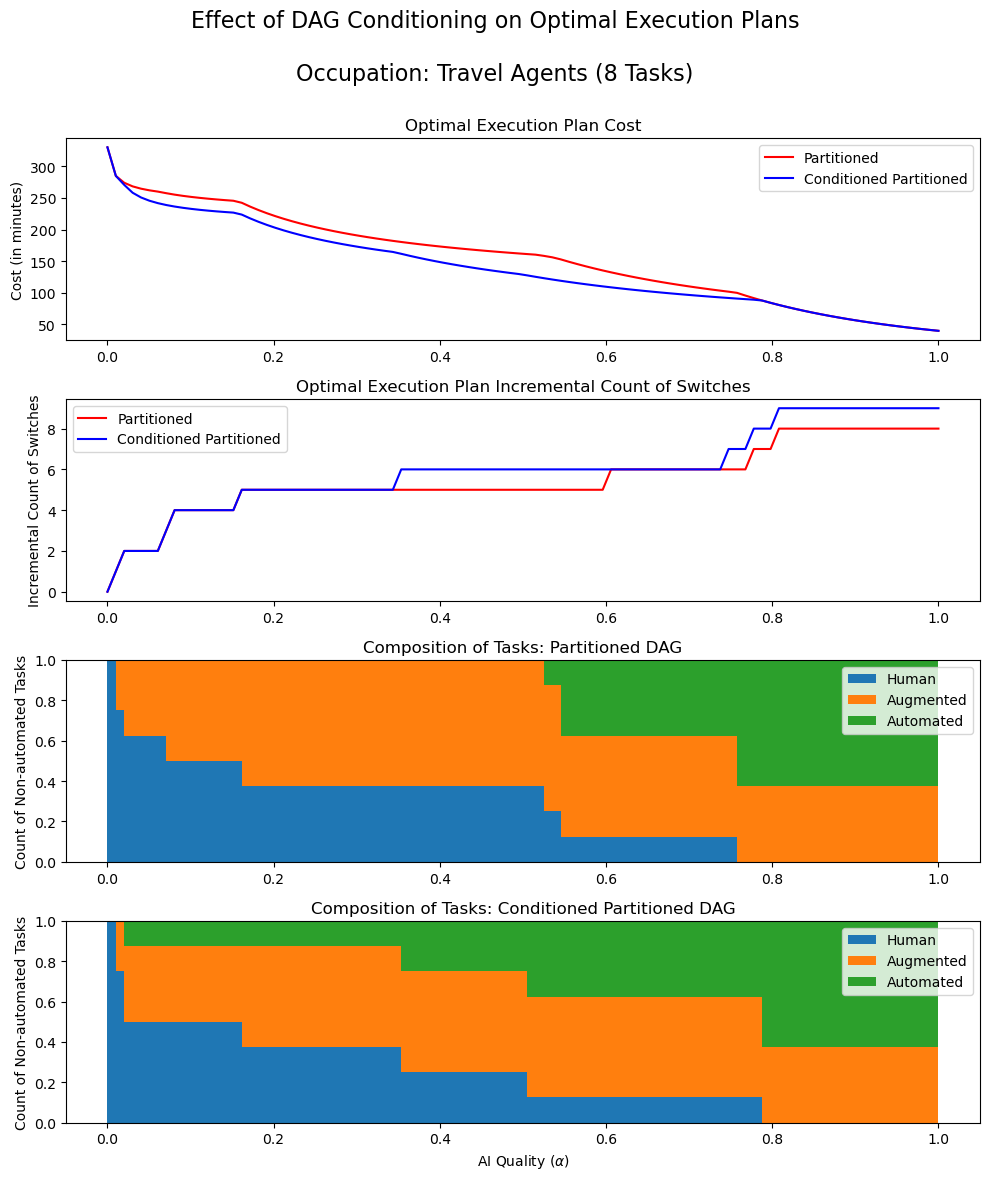

In [106]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
fig.suptitle(f'Effect of DAG Conditioning on Optimal Execution Plans\n\nOccupation: {plot_title_occupation} ({num_tasks} Tasks)\n', fontsize=16)

# Plot data on the first subplot
ax1.plot(comparison_df.alpha, comparison_df.cost_P, label = 'Partitioned', color='red')
ax1.plot(comparison_df.alpha, comparison_df.cost_CP, label = 'Conditioned Partitioned', color='blue')

ax1.set_title('Optimal Execution Plan Cost')
#ax1.set_xlabel(r'AI Quality ($\alpha$)')
ax1.set_ylabel('Cost (in minutes)')
ax1.legend(loc='upper right')


# Plot data on the second subplot
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_FLT_change, label = 'Partitioned', color='red')
ax2.plot(comparison_df.alpha, comparison_df.optimal_scheme_CFLT_change, label = 'Conditioned Partitioned', color='blue')

ax2.set_title('Optimal Execution Plan Incremental Count of Switches')
#ax2.set_xlabel(r'AI Quality ($\alpha$)')
ax2.set_ylabel('Incremental Count of Switches')
ax2.legend(loc='upper left')


# Plot data on the third subplot
alpha_list = comparison_df.alpha.tolist()
widths = np.diff(alpha_list, append=alpha_list[-1])
ax3.bar(comparison_df.alpha, comparison_df.frac_human_P, width=widths, align='edge', label='Human')
ax3.bar(comparison_df.alpha, comparison_df.frac_augmented_P, bottom=comparison_df.frac_human_P, width=widths, align='edge', label='Augmented')
ax3.bar(comparison_df.alpha, comparison_df.frac_automated_P, bottom=comparison_df.frac_human_P + comparison_df.frac_augmented_P, width=widths, align='edge', label='Automated')

ax3.set_title('Composition of Tasks: Partitioned DAG')
#ax3.set_xlabel(r'AI Quality ($\alpha$)')
ax3.set_ylabel('Count of Non-automated Tasks')
ax3.legend(loc='upper right')



ax4.bar(comparison_df.alpha, comparison_df.frac_human_CP, width=widths, align='edge', label='Human')
ax4.bar(comparison_df.alpha, comparison_df.frac_augmented_CP, bottom=comparison_df.frac_human_CP, width=widths, align='edge', label='Augmented')
ax4.bar(comparison_df.alpha, comparison_df.frac_automated_CP, bottom=comparison_df.frac_human_CP + comparison_df.frac_augmented_CP, width=widths, align='edge', label='Automated')

ax4.set_title('Composition of Tasks: Conditioned Partitioned DAG')
ax4.set_xlabel(r'AI Quality ($\alpha$)')
ax4.set_ylabel('Count of Non-automated Tasks')
ax4.legend(loc='upper right')

# Adjust the layout
plt.tight_layout()

# Save the plot
plt.savefig(f'{occupation_folder}/{occupation}_conditioningComparison_P_graph.png', dpi=300)
plt.savefig(f'{data_path}/daily_tasks_occupations_analysis/plots/P_conditioning/{occupation}_condComparison_P_graph.png', dpi=300)

# # Close figure
# plt.close()